['malignant' 'benign']
target
 1    357
-1    212
Name: count, dtype: int64
First five rows of the dataset:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430    

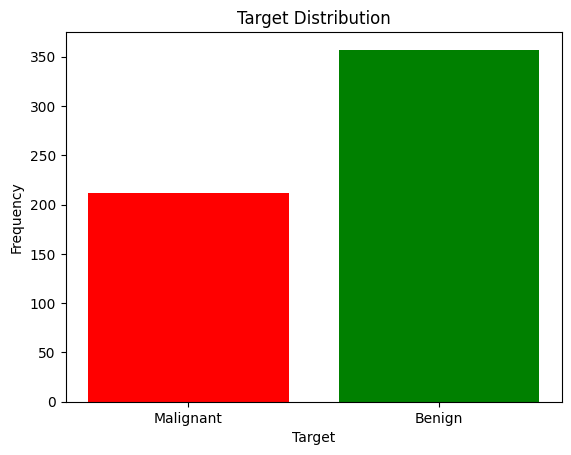

Malignant (-1):  212
Benign (1):  357


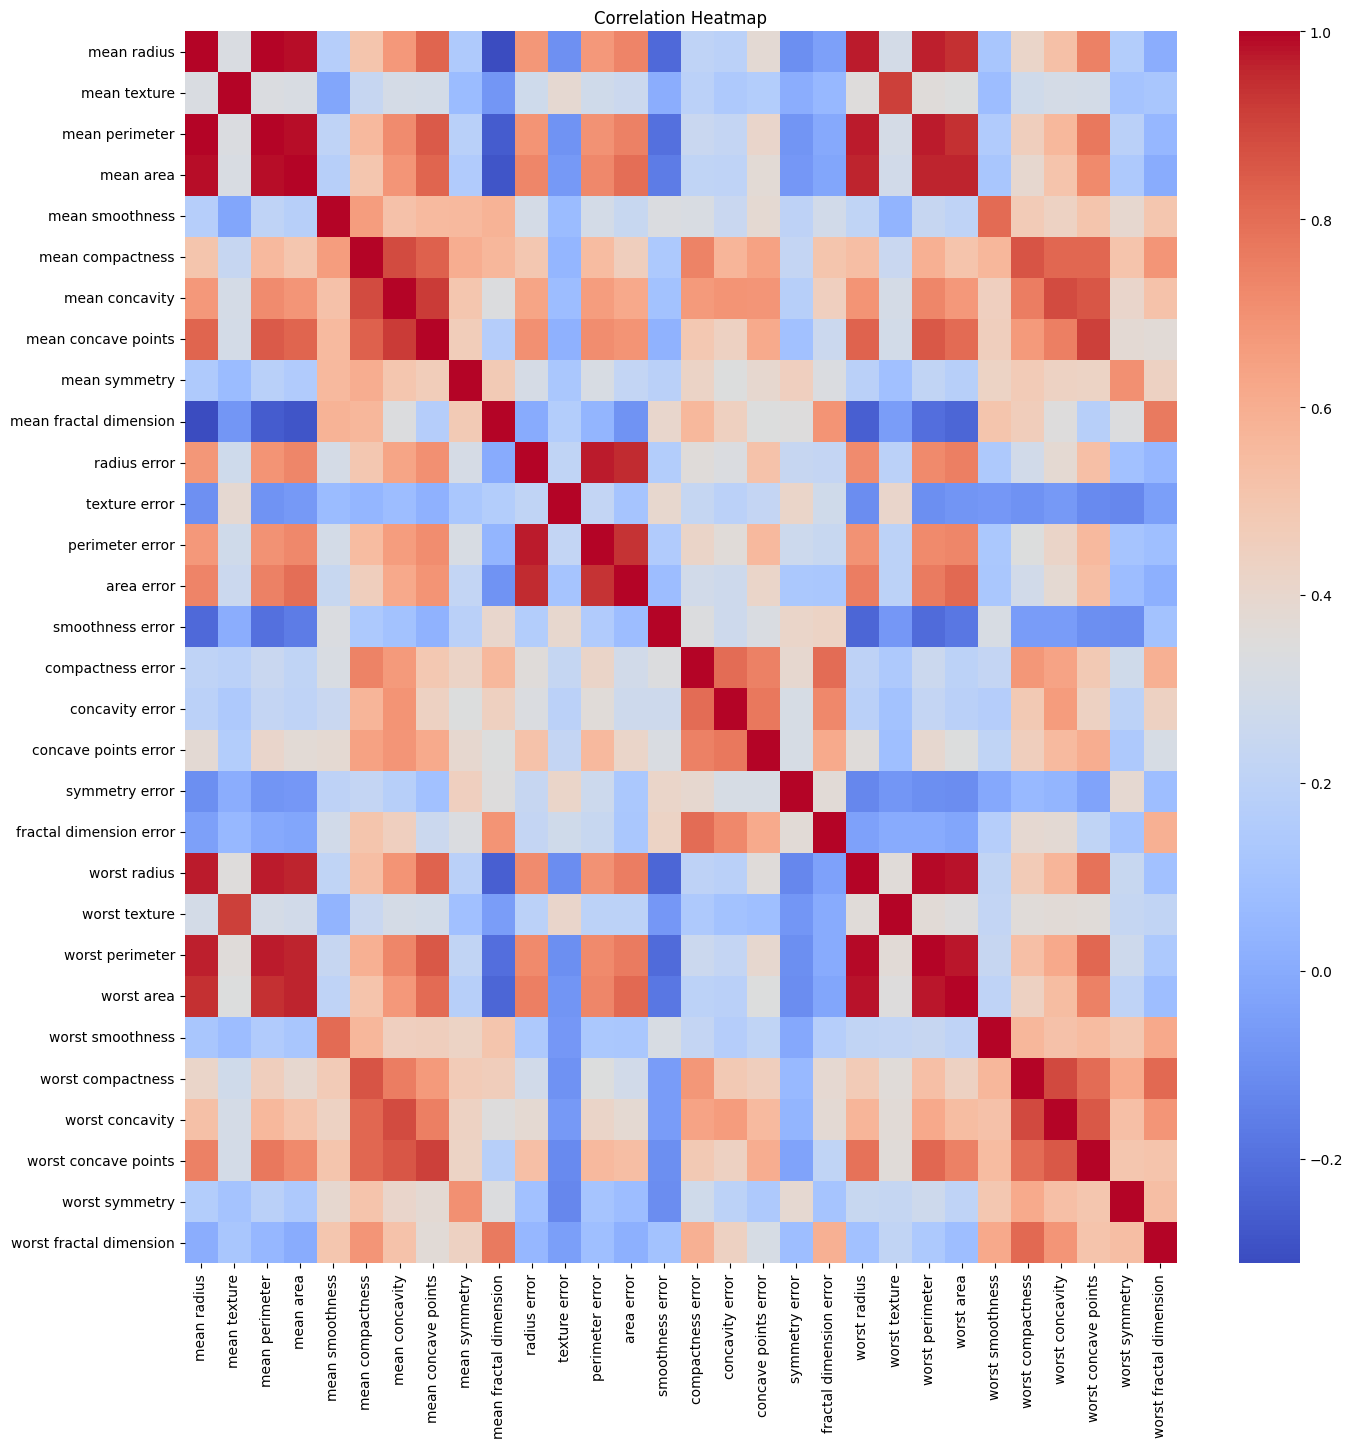

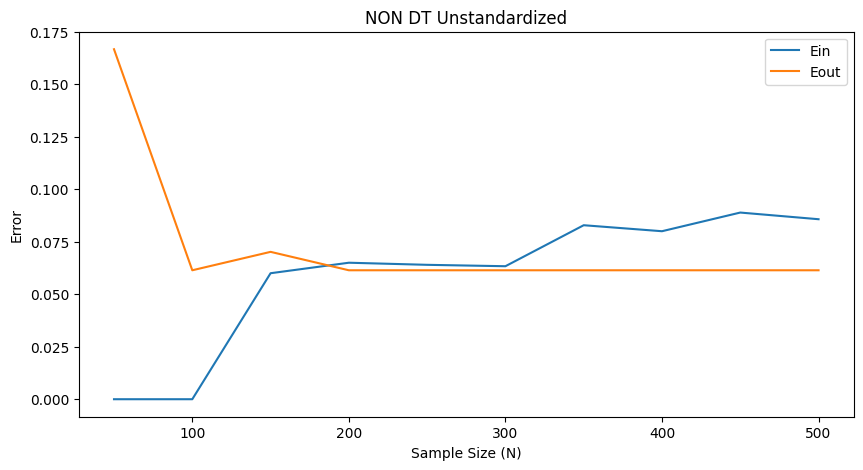

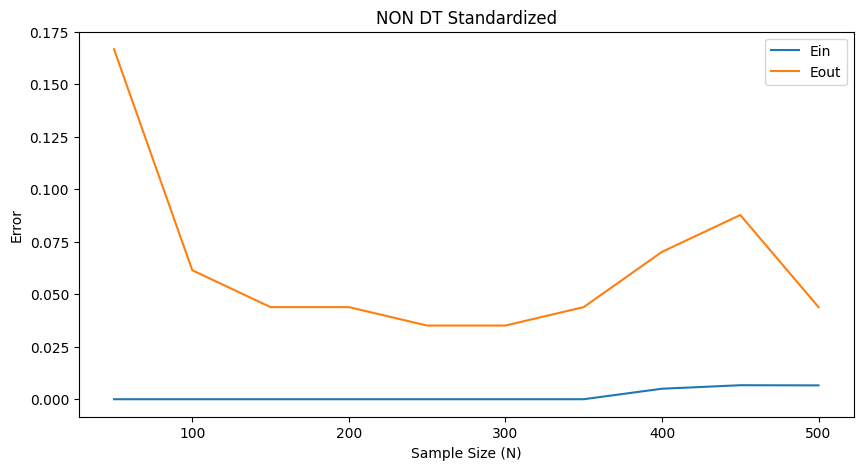

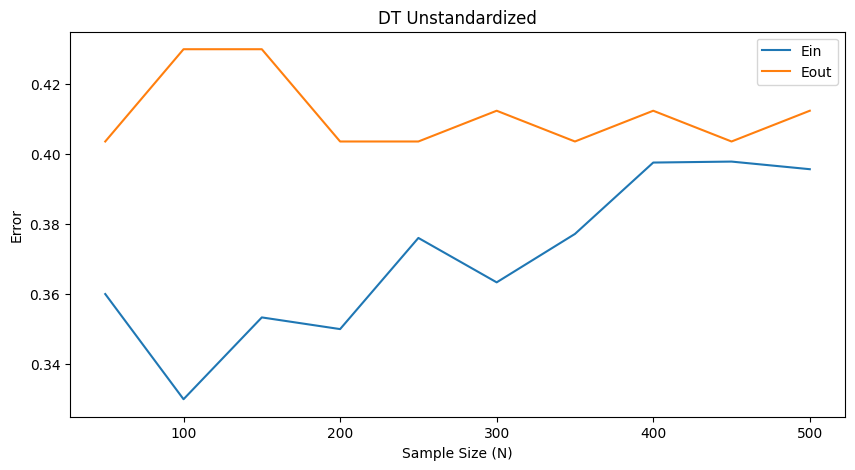

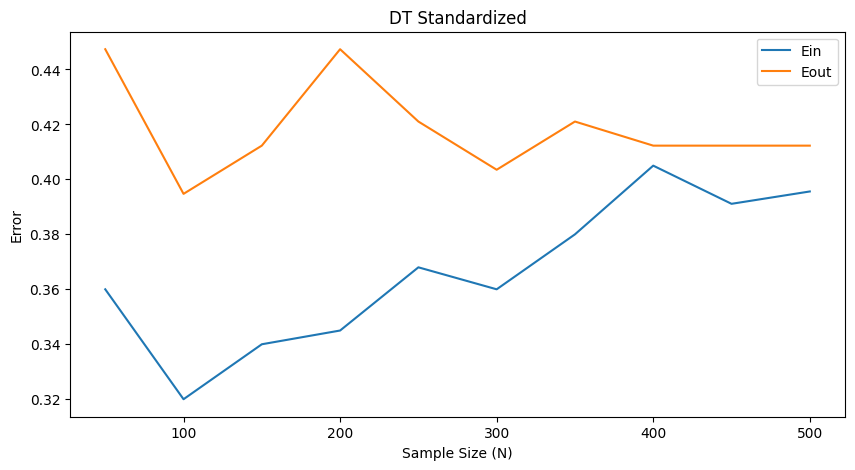

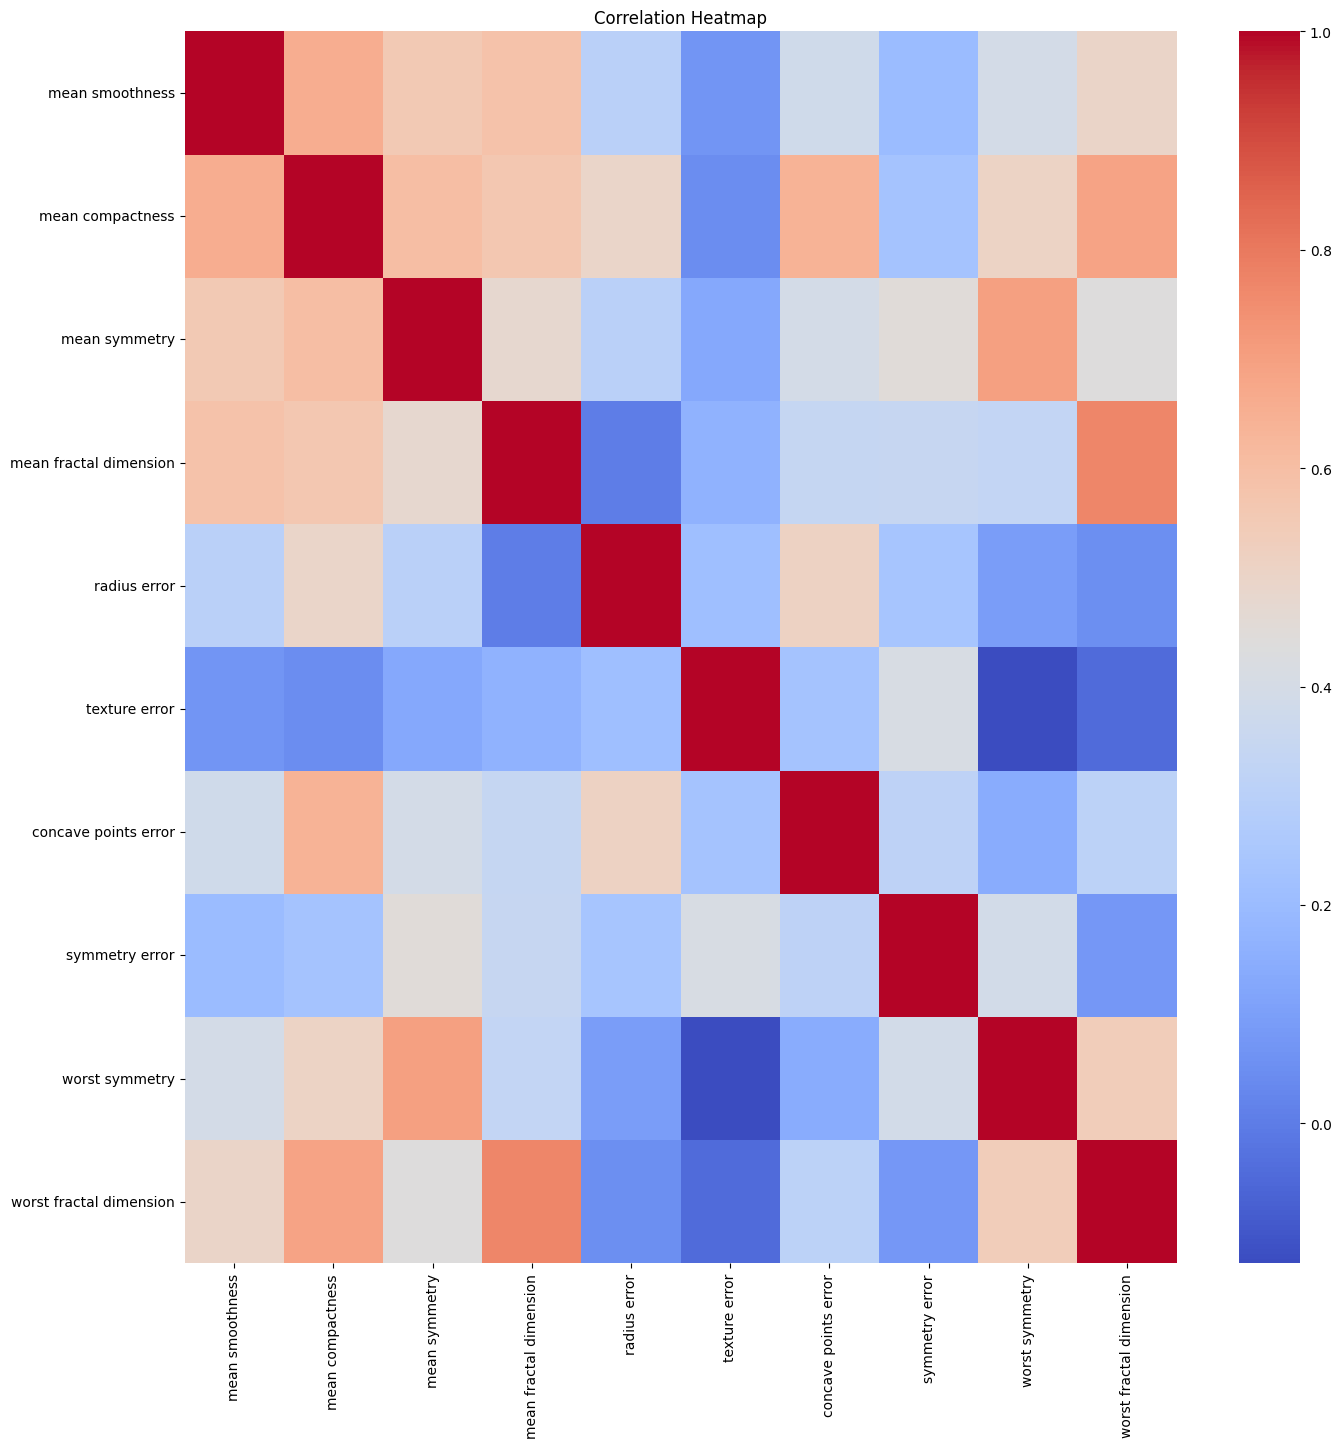

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

class PocketAlgorithm:
    def __init__(self, num_iterations=500, learning_rate=0.01):
        self.num_iterations = num_iterations    
        self.learning_rate = learning_rate
        self.w = None

    def linear_regression_weight(self, X, y):
        return np.linalg.pinv(X.T @ X) @ X.T @ y

    def predict(self, X):
        return np.sign(X @ self.w)

    def train(self, X, y):
        self.w = self.linear_regression_weight(X, y)
        best_w = self.w.copy()
        best_accuracy = 0

        for _ in range(self.num_iterations):
            misclassified = np.where(self.predict(X) * y <= 0)[0]

            if len(misclassified) == 0:
                break

            index = np.random.choice(misclassified)
            self.w = self.w + self.learning_rate * y[index] * X[index]

            accuracy = accuracy_score(y, self.predict(X))
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_w = self.w.copy()

        self.w = best_w

def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    return X_train_std, X_test_std


def run_experiment(X, y, sample_size, standardized=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if standardized:
        X_train, X_test = standardize_data(X_train, X_test)
    
    X_train = np.column_stack([np.ones(X_train.shape[0]), X_train])
    X_test = np.column_stack([np.ones(X_test.shape[0]), X_test])

    Ein_values = []
    Eout_values = []

    for N in sample_size:
        # N goes up to 500, training set only has 455 points
        N = min(N, X_train.shape[0])
        X_subset = X_train[:N]
        y_subset = y_train[:N]

        pocket = PocketAlgorithm()
        pocket.train(X_subset, y_subset)

        Ein = 1 - accuracy_score(y_subset, pocket.predict(X_subset))
        Eout = 1 - accuracy_score(y_test, pocket.predict(X_test))

        Ein_values.append(Ein)
        Eout_values.append(Eout)

    return Ein_values, Eout_values

def plot_results(title, sample_sizes, Ein_values, Eout_values):
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, Ein_values, label='Ein')
    plt.plot(sample_sizes, Eout_values, label='Eout')
    plt.xlabel('Sample Size (N)')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.show()

def load_data():
    breast_cancer = load_breast_cancer()
    X, y = breast_cancer.data, breast_cancer.target
    print(breast_cancer.target_names)
    df = pd.DataFrame(X, columns=breast_cancer.feature_names)
    # convert to -1 (malignant) and 1 (benign)
    y = 2 * y - 1

    # making the data balanced by randomly sampling benign points
    # malignant_indices = np.where(y == -1)[0]
    # benign_indices = np.random.choice(np.where(y == 1)[0], size=len(malignant_indices), replace=False)
    # balanced = np.concatenate([malignant_indices, benign_indices])
    # np.random.shuffle(balanced)

    # X = X[balanced]
    # y = y[balanced]

    # df = pd.DataFrame(X, columns=breast_cancer.feature_names)

    df['target'] = y
    print(df['target'].value_counts())
    return df, X, y

def perform_eda(df):
    print("First five rows of the dataset:")
    print(df.head())
    print("\nSummary statistics:")
    print(df.describe())
    print("\nMissing values in each column:")
    print(df.isnull().sum())

def plot_correclation_heatmap(df):
    plt.figure(figsize=(16, 16))
    sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

def plot_target_distribution(df):
    classes = ['Malignant', 'Benign']
    counts = [np.sum(df['target'] == -1), np.sum(df['target'] == 1)]
    plt.bar(classes, counts, color=['red', 'green'])
    plt.title('Target Distribution')
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.show()

    print("Malignant (-1): ", counts[0])
    print("Benign (1): ", counts[1])

def uncorrelate_features(df, remove_features):
    return df.drop(columns=remove_features)


if __name__ == "__main__":
    df, X, y = load_data()
    perform_eda(df)
    plot_target_distribution(df)
    plot_correclation_heatmap(df.drop('target', axis=1))

    sample_size = np.linspace(50, 500, 10, dtype=int)

    Ein, Eout = run_experiment(X, y, sample_size, standardized=False)
    plot_results("NON DT Unstandardized", sample_size, Ein, Eout)

    Ein, Eout = run_experiment(X, y, sample_size, standardized=True)
    plot_results("NON DT Standardized", sample_size, Ein, Eout)

    remove_features = [
        "mean radius",
        "mean perimeter",
        "mean area",
        "mean texture",
        "mean concavity", 
        "mean concave points", 
        "perimeter error", 
        "area error", 
        "concavity error", 
        "smoothness error",
        "compactness error",
        "fractal dimension error", 
        "worst radius", 
        "worst texture", 
        "worst perimeter", 
        "worst area", 
        "worst compactness", 
        "worst concavity", 
        "worst concave points",
        "worst smoothness"
    ]

    df_uncorrelated = uncorrelate_features(df, remove_features)
    X_uncorrelated = df_uncorrelated.drop('target', axis=1).values
    y_uncorrelated = df_uncorrelated['target'].values
    y_uncorrelated = 2 * y_uncorrelated - 1

    Ein, Eout = run_experiment(X_uncorrelated, y_uncorrelated, sample_size, standardized=False)
    plot_results("DT Unstandardized", sample_size, Ein, Eout)

    Ein, Eout = run_experiment(X_uncorrelated, y_uncorrelated, sample_size, standardized=True)
    plot_results("DT Standardized", sample_size, Ein, Eout)

    plot_correclation_heatmap(df_uncorrelated.drop('target', axis=1))